In [1]:
# Import
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score,recall_score,precision_score
from imblearn.under_sampling import RandomUnderSampler

import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

In [2]:
df1 = pd.read_csv(r".\accepted_2007_to_2018Q4.csv")
df1.head()

# set id as index
df1.set_index('id', inplace = True)

# grab the features which we think might impact the dependent variable 'loan_status' according to the description 
df=df1[['loan_amnt','term','grade','annual_inc','verification_status','dti','delinq_2yrs','fico_range_high','inq_last_6mths','open_acc','pub_rec','revol_bal',\
        'revol_util','total_acc','avg_cur_bal','total_rev_hi_lim','acc_open_past_24mths','pct_tl_nvr_dlq','loan_status']]

# drop all rows with nan 
df.dropna(inplace = True)

# change predicting variables into 1 and 0
df = df[df['loan_status'].isin(['Fully Paid','Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default'])]
df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0, 'Late (31-120 days)':0, 'Late (16-30 days)':0, 'Default':0})

# convert all categorical values into numerical values
obj_df = df.select_dtypes(include=['object']).copy()
for name in obj_df.columns:
    df[name] = df[name].astype('category').cat.codes

# new dataset size
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')

<ipython-input-2-8589f9410366>:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r".\accepted_2007_to_2018Q4.csv")
<ipython-input-2-8589f9410366>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
<ipython-input-2-8589f9410366>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0, 'Late (31-120 days)':0, 'Late (16-30 days)':0, 'Default':0})


New dataset has 1302276 rows, and 19 columns.


In [ ]:
# Define features and target
X = df.loc[:, df.columns != 'loan_status']      # Features
y = df['loan_status']                           # Target

#balance
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X, y = rus.fit_resample(X, y)
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')

Train and Test Size 397306, 170274
New dataset has 1302276 rows, and 19 columns.


In [ ]:
def get_classification(predictions,threshold):
    classes = np.zeros_like(predictions)
    for i in range(len(classes)):
        if predictions[i] > threshold:
            classes[i] = 1
    return classes

In [ ]:
def Measure1(y_true, y_pred,method,number,thresholds = 0.5):
    if type(y_pred[0] == 'float32'):
        y_pred1 = get_classification(y_pred,thresholds)
    else:
        y_pred1 = y_pred
    accuracy=accuracy_score(y_true, y_pred1)
#     precision=precision_score(y_true, y_pred,pos_label=0)
#     recall=recall_score(y_true, y_pred,pos_label=0)
    precision=precision_score(y_true, y_pred1)
    recall=recall_score(y_true, y_pred1)
    tn, fp, fn, tp=confusion_matrix(np.ravel(y_true),y_pred1).ravel()
    matrix=confusion_matrix(np.ravel(y_true),y_pred1)
    (fpr, tpr, thresholds) = roc_curve(y_true,y_pred)
    area = auc(fpr,tpr)
#     pl.clf() #Clear the current figure
    plt.figure(number,figsize=(10,8))
    pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)
    pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(method+' ROC')
    pl.legend(loc="lower right")
    pl.show()
    print('tn',tn,'fp',fp,'fn',fn,'tp',tp)
    print('matrix',matrix,'accuracy',accuracy,'precision',precision,'recall',recall,'ROC',area)
    
    #plot confusion matrix
    plt.figure(number*3)
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    return matrix,accuracy,precision,recall

In [ ]:
#Basic linear regression
def Basic_linear_regression(X_train, X_test, y_train, y_test):
    
    # standardise X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    return y_pred

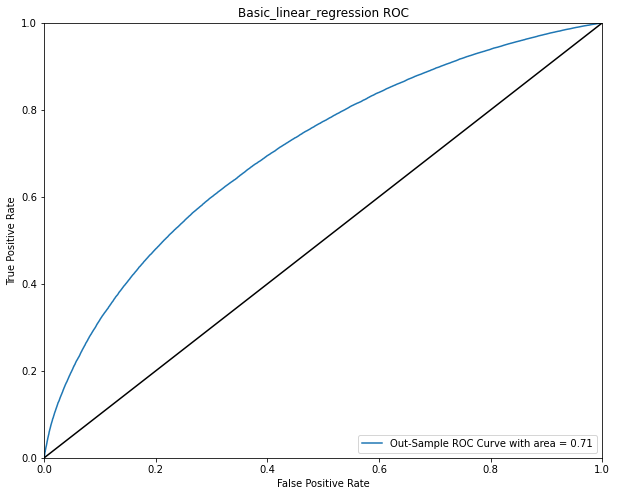

tn 53788 fp 31206 fn 28567 tp 56713
matrix [[53788 31206]
 [28567 56713]] accuracy 0.648959911671776 precision 0.6450596571844539 recall 0.6650211069418387 ROC 0.7061034645763098


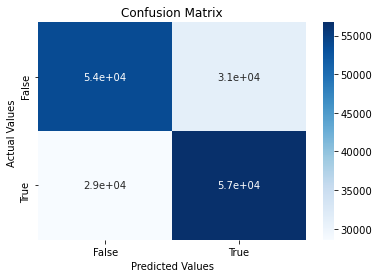

In [ ]:
y_pred=Basic_linear_regression(X_train, X_test, y_train, y_test)
matrix,accuracy,precision,recall=Measure1(y_test, y_pred,'Basic_linear_regression',0,0.5)

In [ ]:
#Linear regressions with Lasso 
def linear_regression_lasso(X_train, X_test, y_train, y_test):

    # standardise X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    lassocv = LassoCV(alphas=np.logspace(-3.5,-0.5,500), fit_intercept=False, positive=True, cv=5)
    # cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2)
    lassocv.fit(X_train, y_train)
    alpha_df = pd.DataFrame({"alpha":lassocv.alphas_, "mse":lassocv.mse_path_.mean(1)})
    best_alpha = alpha_df[alpha_df.mse == alpha_df.mse.max()].alpha
    alpha = best_alpha.values[0]
    
    lasso = Lasso(alpha=alpha)
    y_pred = lasso.fit(X_train, y_train).predict(X_test)
    coef=lasso.coef_
    
    plt.hist(coef, bins=50)
    
    return y_pred,coef

[-0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0.  0. -0.  0.  0.  0. -0.  0.]


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


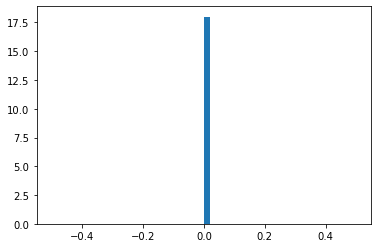

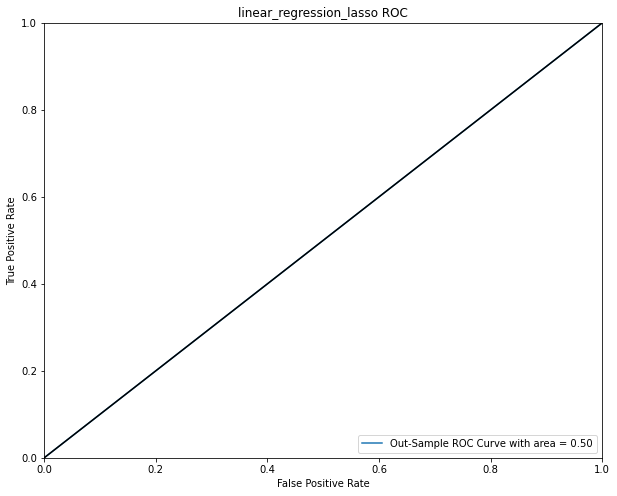

tn 84994 fp 0 fn 85280 tp 0
matrix [[84994     0]
 [85280     0]] accuracy 0.4991601771262788 precision 0.0 recall 0.0 ROC 0.5


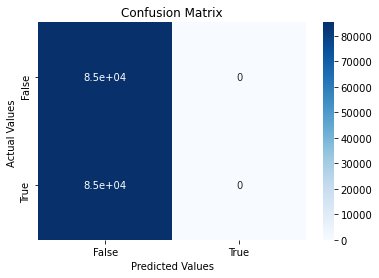

In [ ]:
y_pred,coef=linear_regression_lasso(X_train, X_test, y_train, y_test)
print(coef)
matrix,accuracy,precision,recall=Measure1(y_test, y_pred,'linear_regression_lasso',0,0.5)

In [ ]:
#Linear regressions with Ridge
def linear_regression_ridge(X_train, X_test, y_train, y_test):

    # standardise X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    ridge=RidgeCV(alphas=[0.1, 1.0, 10.0]) 
    y_pred = ridge.fit(X_train, y_train).predict(X_test)    
    coef=ridge.coef_
    
    return y_pred,coef

[-0.02678566 -0.05583309 -0.0916055   0.00997788 -0.01041868 -0.02435469
 -0.01247173  0.03420386 -0.00800579 -0.01002826  0.00023425 -0.00088825
  0.00105562  0.04437766  0.03579817  0.0076479  -0.03986269 -0.00159245]


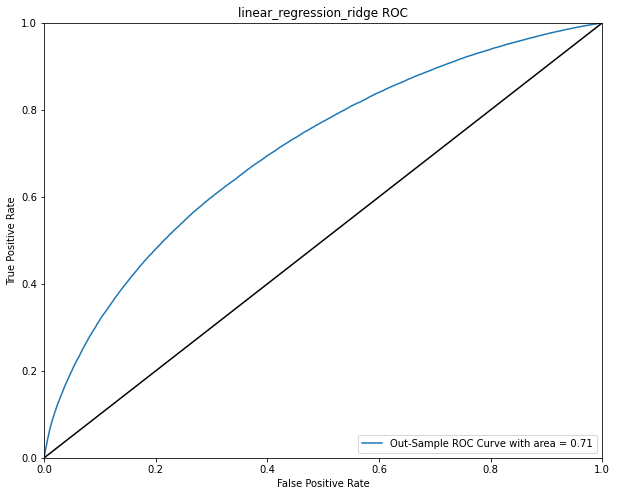

tn 53788 fp 31206 fn 28567 tp 56713
matrix [[53788 31206]
 [28567 56713]] accuracy 0.648959911671776 precision 0.6450596571844539 recall 0.6650211069418387 ROC 0.7061034213937009


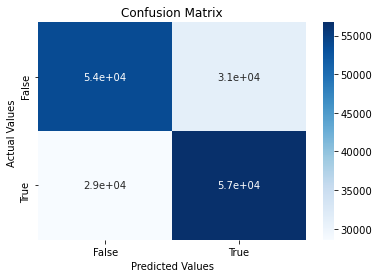

In [ ]:
y_pred,coef=linear_regression_ridge(X_train, X_test, y_train, y_test)
print(coef)
matrix,accuracy,precision,recall=Measure1(y_test, y_pred,'linear_regression_ridge',0,0.5)

In [ ]:
def Measure2(y_true, y_pred,method,number):
    accuracy=accuracy_score(y_true, y_pred)
#     precision=precision_score(y_true, y_pred,pos_label=0)
#     recall=recall_score(y_true, y_pred,pos_label=0)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    tn, fp, fn, tp=confusion_matrix(np.ravel(y_test),y_pred).ravel()
    matrix=confusion_matrix(np.ravel(y_test),y_pred)
    (fpr, tpr, thresholds) = roc_curve(y_test,y_pred)
    area = auc(fpr,tpr)
#     pl.clf() #Clear the current figure
    plt.figure(number,figsize=(10,8))
    pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)
    pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(method+' ROC')
    pl.legend(loc="lower right")
    pl.show()
    print('tn',tn,'fp',fp,'fn',fn,'tp',tp)
    print('matrix',matrix,'accuracy',accuracy,'precision',precision,'recall',recall,'ROC',area)
    
    #plot confusion matrix
    plt.figure(number*3)
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    return matrix,accuracy,precision,recall

In [ ]:
#Logistic
def Logistic(X_train, X_test, y_train, y_test):
    lo = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegressionCV(solver='saga',max_iter=10000, Cs=1))
])
    lo.fit(X_train, y_train)
    y_pred = lo.predict(X_test)
    coef=lo['regressor'].coef_[0]
    
    # sorting
    coef_lr = pd.DataFrame({'var' : X_test.columns,
                        'coef' : coef.flatten()
                        })

    index_sort =  np.abs(coef_lr['coef']).sort_values().index
    coef_lr_sort = coef_lr.loc[index_sort,:]

    # plot
    fig,ax=plt.subplots(figsize=(10,10))
    x, y = coef_lr_sort['var'], coef_lr_sort['coef']
    rects = plt.barh(x, y, color='dodgerblue')
    plt.title('Feature Importances')
    plt.grid(linestyle="-.", axis='y', alpha=0.4)
    plt.tight_layout()
        
    for rect in rects:
        w = rect.get_width()
        ax.text(w, rect.get_y()+rect.get_height()/2,'%.2f' %w,ha='left',va='center')
    
    return y_pred,coef

[-0.12293957 -0.23458111 -0.36907031  0.05402681 -0.0485678  -0.15301856
 -0.04553052  0.14730272 -0.04318879 -0.03090456 -0.00122506 -0.00272052
  0.00281634  0.15801206  0.1540796   0.07259516 -0.1587931  -0.00269249]


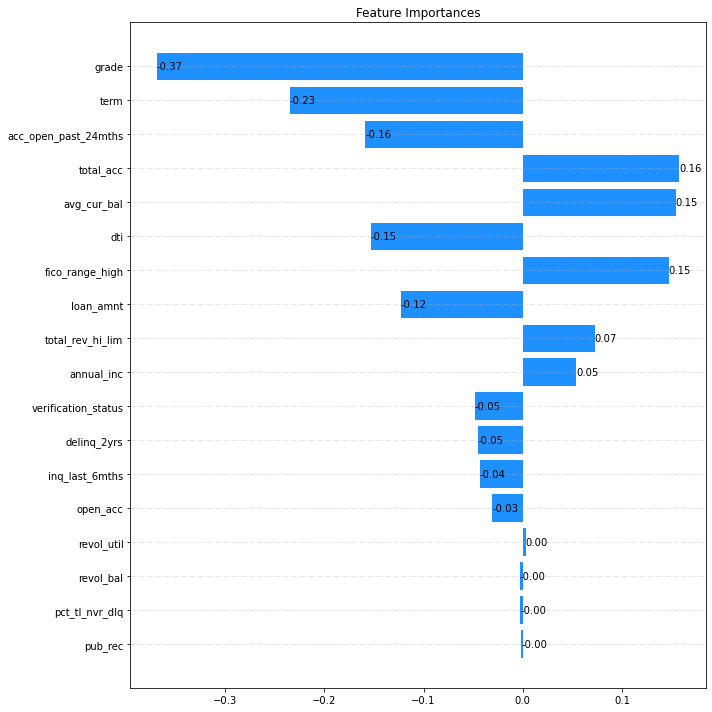

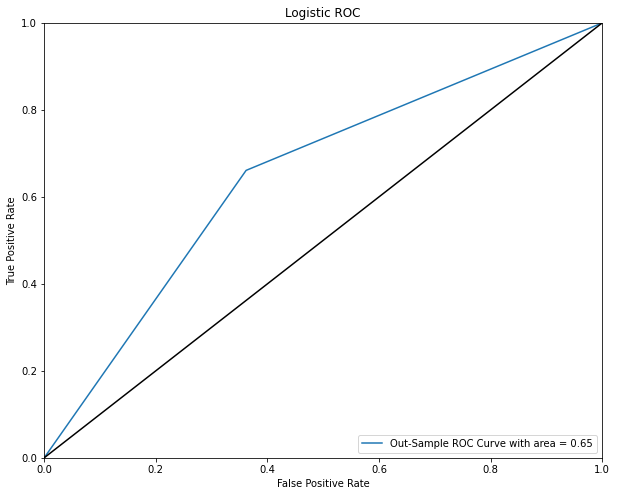

tn 54238 fp 30756 fn 28916 tp 56364
matrix [[54238 30756]
 [28916 56364]] accuracy 0.6495530732818868 precision 0.646969696969697 recall 0.6609287054409005 ROC 0.6495339341026654


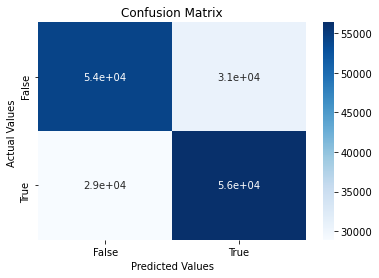

In [ ]:
y_pred,coef=Logistic(X_train, X_test, y_train, y_test)
print(coef)
matrix,accuracy,precision,recall=Measure2(y_test, y_pred,'Logistic',0)

In [ ]:
#Logistic-Ridge Penalty
def Logistic_Ridge_Penalty(X_train, X_test, y_train, y_test):
    rig = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegressionCV(solver='saga',penalty='l2',max_iter=10000, Cs=1))
])
    rig.fit(X_train, y_train)
    y_pred = rig.predict(X_test)
    coef=rig['regressor'].coef_[0]

    # sorting
    coef_lr = pd.DataFrame({'var' : X_test.columns,
                        'coef' : coef.flatten()
                        })

    index_sort =  np.abs(coef_lr['coef']).sort_values().index
    coef_lr_sort = coef_lr.loc[index_sort,:]

    # plot
    fig,ax=plt.subplots(figsize=(10,10))
    x, y = coef_lr_sort['var'], coef_lr_sort['coef']
    rects = plt.barh(x, y, color='dodgerblue')
    plt.title('Feature Importances')
    plt.grid(linestyle="-.", axis='y', alpha=0.4)
    plt.tight_layout()
        
    for rect in rects:
        w = rect.get_width()
        ax.text(w, rect.get_y()+rect.get_height()/2,'%.2f' %w,ha='left',va='center')

    return y_pred,coef

[-0.12293924 -0.23457375 -0.3690728   0.05402715 -0.04856831 -0.15301537
 -0.04553107  0.14730415 -0.04318745 -0.03090544 -0.00122627 -0.00271692
  0.00281209  0.1580106   0.15407859  0.0725936  -0.15879054 -0.00269104]


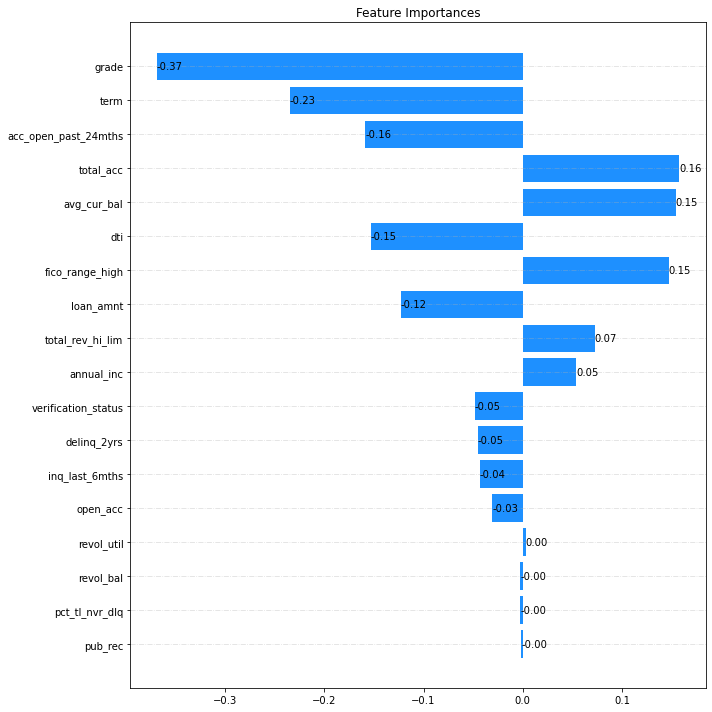

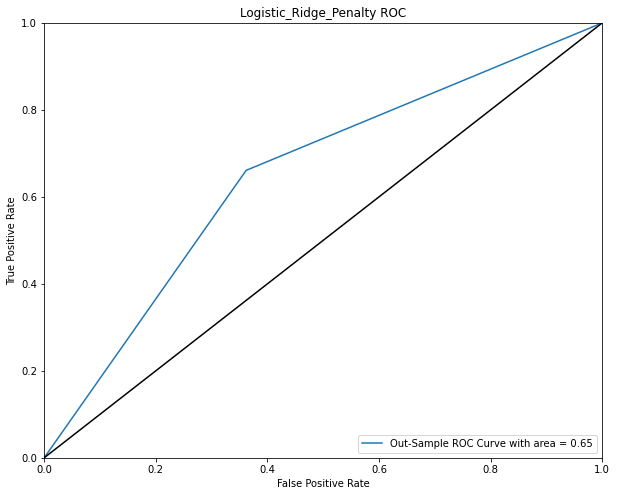

tn 54237 fp 30757 fn 28916 tp 56364
matrix [[54237 30757]
 [28916 56364]] accuracy 0.6495472003946581 precision 0.6469622708646595 recall 0.6609287054409005 ROC 0.6495280513344701


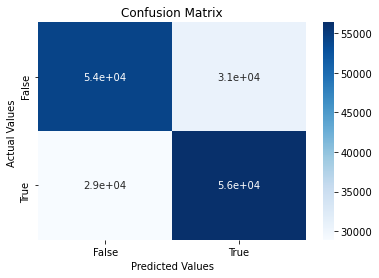

In [ ]:
y_pred,coef=Logistic_Ridge_Penalty(X_train, X_test, y_train, y_test)
print(coef)
matrix,accuracy,precision,recall=Measure2(y_test, y_pred,'Logistic_Ridge_Penalty',0)

In [ ]:
#Logistic-Lasso Penalty
def Logistic_Lasso_Penalty(X_train, X_test, y_train, y_test):
    laso = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegressionCV(solver='saga',penalty='l1',max_iter=10000, Cs=1))
])
    laso.fit(X_train, y_train)
    y_pred = laso.predict(X_test)
    coef=laso['regressor'].coef_[0]
    
    return y_pred,coef

[ 0.         -0.1386227  -0.46404994  0.          0.         -0.00591615
  0.          0.05638107  0.          0.          0.          0.
  0.          0.          0.07002976  0.         -0.02906516  0.        ]


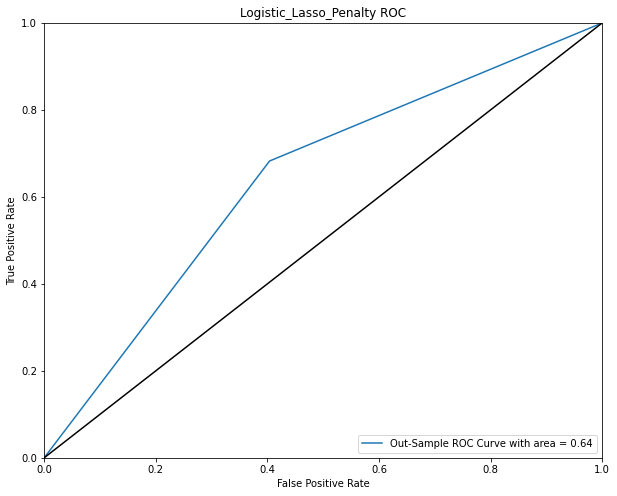

tn 50668 fp 34326 fn 27081 tp 58199
matrix [[50668 34326]
 [27081 58199]] accuracy 0.6393636139398852 precision 0.6290083761145636 recall 0.6824460600375235 ROC 0.6392911289433918


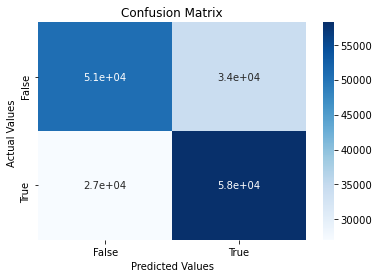

In [ ]:
y_pred,coef=Logistic_Lasso_Penalty(X_train, X_test, y_train, y_test)
print(coef)
matrix,accuracy,precision,recall=Measure2(y_test, y_pred,'Logistic_Lasso_Penalty',0)